<a href="https://colab.research.google.com/github/plthiyagu/AI-Engineering/blob/master/10-TimeSeries/Feature_Selection_for_Time_Series_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [ ]:
!pip install xgbfir
!pip install numba
!pip install parfit
!pip install holidays
!pip install featexp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from numba import jit
from math import log
import numpy as np
from bisect import bisect_right
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
import parfit.parfit as pf
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from IPython.display import Image, display
import pydotplus
import os 
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import _tree
from sklearn.metrics import make_scorer
from tqdm import tqdm
import seaborn as sns
import joblib
import xgbfir
import itertools
import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *
import holidays
from sklearn.metrics import mean_absolute_error
from featexp import get_trend_stats, get_grouped_data
from scipy.stats import linregress
import os 
import random

def seed_everything(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(42)

sns.set()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("talk")

from google.colab import drive

pd.options.display.max_rows = 4000
pd.options.display.max_seq_items = 2000
pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings('ignore')

drive.mount('/mntDrive', force_remount = True) 

     |████████████████████████████████| 153kB 17.9MB/s 
  Created wheel for parfit: filename=parfit-0.220-cp37-none-any.whl size=8661 sha256=b36e04ed5d7e39f828c4db219909927704f9fd8f053fa75dfa1a0576cbb079d7
  Stored in directory: /root/.cache/pip/wheels/d9/8a/c9/ed86e85ad0cb41ce2fdcb6bc215902dc475bd3fb1fef7c742d
Successfully built parfit


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


Mounted at /mntDrive


# **Load Data**

In [ ]:
path = ''
file = ''
data = pd.read_csv(path + file, parse_dates = ['validdate'])
events = pd.read_csv(path+'', parse_dates=['validdate'])
data = pd.merge(data, events, left_on = ['validdate', 'LOCATION_NAME'], right_on = ['validdate', 'LOCATION_NAME'])
train = data[(data['DATE']>0) & (data['validdate']<'2020-05-02') & (data['validdate']>'2019-05-10')]
test = data[data['validdate']>='2020-05-02']

# **Useful functions**


*   **apply_binning**, **get_tree**, **tree_cutpoints**, **get_readable_cutpoints** - functions for univariate supervised discretization based on regression trees, optimized by their depth via cross-validation.

*   **encode_data_ohe** - one-hot encoding for train and test preserving same columns, missing values handling

*   **add_interactions** = dumping trained xgboost model, parsing and cleaning interactions, filtering only stable interactions by Gain Rank, assigning interactions of depth 2,3,4 to original dataframe (inspired by:

        1.   X He et al. 2014, “Practical Lessons from Predicting Clicks on Ads at Facebook” https://research.fb.com/wp-content/uploads/2016/11/practical-lessons-from-predicting-clicks-on-ads-at-facebook.pdf
        2.   JH Friedman et al. 2005 “Predictive Learning via Rule Ensembles”, https://statweb.stanford.edu/~jhf/ftp/RuleFit.pdf)


*   **draw_feature, get_variable, get_variables** - functions for exploring binary rulesets with Decision Tree (drawing, selecting top variables, selecting specific interactions).

In [ ]:
def mape(y_true, y_pred):
  # problem with MAPE as an error metric
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  return np.abs((y_true - y_pred)/y_true).mean()

def get_tree(X, Y, variable, n_folds, param_grid, mape_scorer):

    param_grid = param_grid
    tree_model = GridSearchCV(DecisionTreeRegressor(random_state=0),
                              cv = n_folds, 
                              scoring = mape_scorer,
                              param_grid = param_grid)


    tree_model.fit(X[[variable]], Y)
    estimator = DecisionTreeRegressor(max_depth=tree_model.best_params_['max_depth'])
    estimator.fit(X[[variable]], Y)
    return estimator

def tree_cutpoints(tree, feature_names):
    cutpoints = []
    d= []
    tree_ = tree.tree_
    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    # print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            # print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            # print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
            
            if (depth==tree.max_depth):
                cutpoints.append(threshold)
              
        else:
            pass
            # print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)
    return cutpoints

def get_readable_cutpoints(val, binning):
    
    dicts = {}
    binning.sort()
    binning = np.round(binning, 6)

    for i, cut in enumerate(binning):
        
        if ((val<=cut) & (i == 0)):
            return 'lt_'+str(binning[i])
        else:
            if ((val>cut) & (i + 1 == len(binning))):
                 return 'gt_'+str(binning[i])
            else:
                 if (val>cut) & (val<=binning[i+1]):
                    return 'btw_'+str(binning[i])+'_and_'+str(binning[i+1])

def encode_float_tree(X_train, X_valid,  Y_train, use_features, numeric_col, target, n_folds, param_grid, scorer):
    for variable in numeric_col:
        
        tree = get_tree(X_train, Y_train, variable, n_folds, param_grid, mape_scorer)
        binning = tree_cutpoints(tree, [variable])
        
        X_train[variable] =  X_train[variable].apply(get_readable_cutpoints, binning = binning)
        X_valid[variable] =  X_valid[variable].apply(get_readable_cutpoints, binning = binning)
       
    return X_train, X_valid

def encode_data_ohe(X_train, X_test, Y_train, use_features, bool_col, cat_col):

    X_train_enc = X_train[use_features].copy()
    X_test_enc = X_test[use_features].copy()

    X_train_enc = X_train_enc.replace([np.inf, -np.inf], np.nan)
    X_test_enc = X_test_enc.replace([np.inf, -np.inf], np.nan)

    X_train_enc[cat_col]=X_train_enc[cat_col].fillna('N/A')
    X_test_enc[cat_col]=X_test_enc[cat_col].fillna('N/A')

    X_train_enc[bool_col]=X_train_enc[bool_col].fillna(0).astype('float')
    X_test_enc[bool_col]=X_test_enc[bool_col].fillna(0).astype('float')

    X_train_ohe = pd.get_dummies(X_train_enc[cat_col])
    X_test_ohe = pd.get_dummies(X_test_enc[cat_col])
    missing_cols = set(X_train_ohe.columns ) - set(X_test_ohe.columns)
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        X_test_ohe[c] = 0
    # Ensure the order of column in the test set is in the same order than in train set
    X_test_ohe = X_test_ohe[X_train_ohe.columns]

    X_train_enc = pd.concat([X_train_enc, X_train_ohe], axis=1)
    X_test_enc = pd.concat([X_test_enc, X_test_ohe], axis=1)

    X_train_enc.drop(cat_col, axis=1, inplace=True)
    X_test_enc.drop(cat_col, axis=1, inplace=True)
    
    X_train_cols = X_train_enc.columns
    X_test_cols = X_test_enc.columns
        
    return X_train_enc, X_test_enc, X_train_cols, X_test_cols

def add_interactions(X_train_enc, X_test_enc, bst, gain_rank_filter):

      xgbfir.saveXgbFI(bst, MaxInteractionDepth=3, OutputXlsxFile=path+'XgbFeatureInteractions.xlsx')
      xl_file = pd.ExcelFile(path+'XgbFeatureInteractions.xlsx')

      dfs = {sheet_name: xl_file.parse(sheet_name) 
                for sheet_name in xl_file.sheet_names}

      interactions = list(dfs['Interaction Depth 1'][dfs['Interaction Depth 1']['Gain Rank']<gain_rank_filter]['Interaction'].unique()) + list(dfs['Interaction Depth 2'][dfs['Interaction Depth 2']['Gain Rank']<gain_rank_filter]['Interaction'].unique())  + list(dfs['Interaction Depth 3'][dfs['Interaction Depth 3']['Gain Rank']<gain_rank_filter]['Interaction'].unique())

      clean_interactions = []
      i = 0

      for var in interactions:
          
          var = list(set(var.split('|')))
          if (len(var) > 1):
            clean_interactions += [var]
          i = i + 1

      clean_interactions.sort()
      clean_interactions = list(clean_interactions for clean_interactions,_ in itertools.groupby(clean_interactions))

      for i in range(0, len(clean_interactions)):
        if (len(clean_interactions[i])==2):
            X_train_enc[clean_interactions[i][0]+'|'+clean_interactions[i][1]]=X_train_enc[clean_interactions[i][0]]*X_train_enc[clean_interactions[i][1]]
            X_test_enc[clean_interactions[i][0]+'|'+clean_interactions[i][1]]=X_test_enc[clean_interactions[i][0]]*X_test_enc[clean_interactions[i][1]]
        if (len(clean_interactions[i])==3):
            X_train_enc[clean_interactions[i][0]+'|'+clean_interactions[i][1]+'|'+clean_interactions[i][2]]=X_train_enc[clean_interactions[i][0]]*X_train_enc[clean_interactions[i][1]]*X_train_enc[clean_interactions[i][2]]
            X_test_enc[clean_interactions[i][0]+'|'+clean_interactions[i][1]+'|'+clean_interactions[i][2]]=X_test_enc[clean_interactions[i][0]]*X_test_enc[clean_interactions[i][1]]*X_test_enc[clean_interactions[i][2]]
        if (len(clean_interactions[i])==4):
            X_train_enc[clean_interactions[i][0]+'|'+clean_interactions[i][1]+'|'+clean_interactions[i][2]+'|'+clean_interactions[i][3]]=X_train_enc[clean_interactions[i][0]]*X_train_enc[clean_interactions[i][1]]*X_train_enc[clean_interactions[i][2]]*X_train_enc[clean_interactions[i][3]]
            X_test_enc[clean_interactions[i][0]+'|'+clean_interactions[i][1]+'|'+clean_interactions[i][2]+'|'+clean_interactions[i][3]]=X_test_enc[clean_interactions[i][0]]*X_test_enc[clean_interactions[i][1]]*X_test_enc[clean_interactions[i][2]]*X_test_enc[clean_interactions[i][3]]
      
      X_train_cols, X_test_cols = X_train_enc.columns, X_test_enc.columns

      return X_train_enc, X_test_enc, X_train_cols, X_test_cols

def draw_feature(selected_cols, max_depth, min_samples_leaf):
        
        clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, criterion='mae')
        clf.fit(X_train_enc[selected_cols], Y_train)
        
        clf_tmp = DecisionTreeRegressor(max_depth=1, min_samples_leaf=min_samples_leaf, criterion = 'mae')
        clf_tmp.fit(X_train_enc[selected_cols], Y_train)
        top_feature = np.array(selected_cols)[clf_tmp.feature_importances_ > 0]
        
        dot_data = StringIO()
        export_graphviz(clf, out_file=dot_data, feature_names = selected_cols,
                        filled=True, rounded=True, proportion = True, impurity = False,
                        special_characters=True,
                        class_names = ['GOOD', 'BAD']
                       )
        graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
        graph.write_png('original_tree.png')
        graph.set_size('"75,!"')
        plt = Image(graph.create_png())
        display(plt)
        return top_feature

def get_variables(coefficients, top = 10):
    var_list = coefficients.sort_values(by = 'weight', ascending = False).head(top)['variable'].unique()

    draw_interactions = []
    i = 0

    for var in var_list:
        
        var = list(set(var.split('|')))
        draw_interactions += var
        i = i + 1

    draw_interactions.sort()
    draw_interactions = list(set(draw_interactions))
    return draw_interactions

def get_variable(coefficients, num = 145):
    var_list = [coefficients.ix[num]['variable']]

    draw_interactions = []
    i = 0

    for var in var_list:
        
        var = list(set(var.split('|')))
        draw_interactions += var
        i = i + 1

    draw_interactions.sort()
    draw_interactions = list(set(draw_interactions))
    return draw_interactions

def xgb_mape(preds, dtrain):
   labels = dtrain.get_label()
   return('mape', -np.mean(np.abs((labels - preds) / (labels + 1))))

class TimeBasedCV(object):
    '''
    Parameters 
    ----------
    train_period: int
        number of time units to include in each train set
        default is 30
    test_period: int
        number of time units to include in each test set
        default is 7
    freq: string
        frequency of input parameters. possible values are: days, months, years, weeks, hours, minutes, seconds
        possible values designed to be used by dateutil.relativedelta class
        deafault is days
    '''
    
    
    def __init__(self, train_period=30, test_period=7, freq='days'):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq

        
        
    def split(self, data, validation_split_date=None, date_column='record_date', gap=0):
        '''
        Generate indices to split data into training and test set
        
        Parameters 
        ----------
        data: pandas DataFrame
            your data, contain one column for the record date 
        validation_split_date: datetime.date()
            first date to perform the splitting on.
            if not provided will set to be the minimum date in the data after the first training set
        date_column: string, deafult='record_date'
            date of each record
        gap: int, default=0
            for cases the test set does not come right after the train set,
            *gap* days are left between train and test sets
        
        Returns 
        -------
        train_index ,test_index: 
            list of tuples (train index, test index) similar to sklearn model selection
        '''
        
        # check that date_column exist in the data:
        try:
            data[date_column]
        except:
            raise KeyError(date_column)
                    
        train_indices_list = []
        test_indices_list = []

        if validation_split_date==None:
            validation_split_date = data[date_column].min().date() + eval('relativedelta('+self.freq+'=self.train_period)')
        
        start_train = validation_split_date - eval('relativedelta('+self.freq+'=self.train_period)')
        end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
        start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
        end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        while end_test < data[date_column].max().date():
            # train indices:
            cur_train_indices = list(data[(data[date_column].dt.date>=start_train) & 
                                     (data[date_column].dt.date<end_train)].index)

            # test indices:
            cur_test_indices = list(data[(data[date_column].dt.date>=start_test) &
                                    (data[date_column].dt.date<end_test)].index)
            
            print("Train period:",start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
                  "# train records", len(cur_train_indices), ", # test records", len(cur_test_indices))

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)

            # update dates:
            start_train = start_train + eval('relativedelta('+self.freq+'=self.test_period)')
            end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
            start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
            end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        # mimic sklearn output  
        index_output = [(train,test) for train,test in zip(train_indices_list,test_indices_list)]

        self.n_splits = len(index_output)
        
        return index_output
    
    
    def get_n_splits(self):
        """Returns the number of splitting iterations in the cross-validator
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return self.n_splits 

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) 

def is_holiday(date, country='NL'):
  nl_holidays = holidays.CountryHoliday('NL')
  return int(date in nl_holidays)

def is_3days_before_holiday(date, country='NL'):
  nl_holidays = holidays.CountryHoliday('NL')
  return int((date + pd.to_timedelta(1, unit="D") in nl_holidays)|(date + pd.to_timedelta(2, unit="D") in nl_holidays)|(date + pd.to_timedelta(3, unit="D") in nl_holidays))

def is_3days_after_holiday(date, country='NL'):
  nl_holidays = holidays.CountryHoliday('NL')
  return int((date - pd.to_timedelta(1, unit="D") in nl_holidays)|(date - pd.to_timedelta(2, unit="D") in nl_holidays)|(date - pd.to_timedelta(3, unit="D") in nl_holidays))

def is_6days_before_holiday(date, country='NL'):
  nl_holidays = holidays.CountryHoliday('NL')
  return int((date + pd.to_timedelta(1, unit="D") in nl_holidays)|(date + pd.to_timedelta(2, unit="D") in nl_holidays)|(date + pd.to_timedelta(3, unit="D") in nl_holidays)|
             (date + pd.to_timedelta(4, unit="D") in nl_holidays)|(date + pd.to_timedelta(5, unit="D") in nl_holidays)|(date + pd.to_timedelta(6, unit="D") in nl_holidays))

def is_6days_after_holiday(date, country='NL'):
  nl_holidays = holidays.CountryHoliday('NL')
  return int((date - pd.to_timedelta(1, unit="D") in nl_holidays)|(date - pd.to_timedelta(2, unit="D") in nl_holidays)|(date - pd.to_timedelta(3, unit="D") in nl_holidays)|
             (date - pd.to_timedelta(4, unit="D") in nl_holidays)|(date - pd.to_timedelta(5, unit="D") in nl_holidays)|(date - pd.to_timedelta(6, unit="D") in nl_holidays))
    
def date_features(data, dt_col):
      data = data.reset_index()
      data[dt_col]=pd.to_datetime(data[dt_col], format = '%Y-%m-%d')
      data['week'] = data[dt_col].dt.week
      data['weekday'] = data[dt_col].dt.weekday
      data['is_summer'] = ((data[dt_col].dt.month >= 5) & (data[dt_col].dt.month <= 9)).astype(int)
      data['is_winter'] = ((data[dt_col].dt.month >= 10) & (data[dt_col].dt.month <= 4)).astype(int)
      # data['is_month_start'] = data[dt_col].dt.is_month_start.astype(int)
      # data['is_month_end'] = data[dt_col].dt.is_month_end.astype(int)
      # data['is_month_middle'] = (data[dt_col].apply(lambda x: x + relativedelta(days=-15))).dt.is_month_start.astype(int)
      
      return data.set_index(dt_col), data.set_index(dt_col).columns
    
    
def holiday_features(data, dt_col):
      data = data.reset_index()
      data[dt_col]=pd.to_datetime(data[dt_col], format = '%Y-%m-%d')
      data['is_holiday'] = data[dt_col].dt.date.apply(is_holiday)
      data['is_3days_before_holiday'] = data[dt_col].dt.date.apply(is_3days_before_holiday)
      data['is_3days_after_holiday'] = data[dt_col].dt.date.apply(is_3days_after_holiday)
      data['is_6days_before_holiday'] = data[dt_col].dt.date.apply(is_6days_before_holiday)
      data['is_3days_after_holiday'] = data[dt_col].dt.date.apply(is_6days_after_holiday)
      
      return data.set_index(dt_col), data.set_index(dt_col).columns
      

# **Define Column Groups - Mobility, Restricitons and Events**



In [ ]:
cols_c = ['retail_and_recreation_percent_change_from_baseline_WEEK_-1',
       'grocery_and_pharmacy_percent_change_from_baseline_WEEK_-1',
       'parks_percent_change_from_baseline_WEEK_-1',
       'transit_stations_percent_change_from_baseline_WEEK_-1',
       'workplaces_percent_change_from_baseline_WEEK_-1',
       'residential_percent_change_from_baseline_WEEK_-1',
       'retail_and_recreation_percent_change_from_baseline_WEEK_-2',
       'grocery_and_pharmacy_percent_change_from_baseline_WEEK_-2',
       'parks_percent_change_from_baseline_WEEK_-2',
       'transit_stations_percent_change_from_baseline_WEEK_-2',
       'workplaces_percent_change_from_baseline_WEEK_-2',
       'residential_percent_change_from_baseline_WEEK_-2']

cols_r =  ['AdaptationOfWorkplace_eq_1', 'ClosDaycare_eq_1',
       'ClosDaycarePartial_eq_1', 'ClosHigh_eq_1', 'ClosHighPartial_eq_1',
       'ClosPrim_eq_1', 'ClosPrimPartial_eq_1', 'ClosPubAnyPartial_eq_1',
       'ClosSec_eq_1', 'ClosSecPartial_eq_1',
       'ClosureOfPublicTransportPartial_eq_1', 'EntertainmentVenues_eq_1',
       'EntertainmentVenuesPartial_eq_1', 'GymsSportsCentres_eq_1',
       'GymsSportsCentresPartial_eq_1', 'IndoorOver100_eq_1',
       'IndoorOver100_eq_3', 'IndoorOver5_eq_1', 'IndoorOver50_eq_1',
       'IndoorOver50_eq_3', 'MasksMandatoryClosedSpaces_eq_1',
       'MasksVoluntaryClosedSpaces_eq_1', 'MassGatherAll_eq_1',
       'MassGatherAll_eq_3', 'MassGatherAllPartial_eq_1',
       'OutdoorOver100_eq_1', 'OutdoorOver5_eq_1', 'OutdoorOver50_eq_1',
       'OutdoorOver500_eq_1', 'PlaceOfWorship_eq_1',
       'PlaceOfWorshipPartial_eq_1', 'RestaurantsCafes_eq_1',
       'RestaurantsCafesPartial_eq_1', 'RestaurantsCafesPartial_eq_3',
       'StayHomeGen_eq_1', 'StayHomeGenPartial_eq_1', 'StayHomeRiskG_eq_1',
       'Teleworking_eq_1', 'WorkplaceClosures_eq_1']

cols_e = [
 'categories.community',
 'categories.concerts',
 'categories.public-holidays',
 'categories.school-holidays',
 'categories.sports',
 'categories_impact.community',
 'categories_impact.concerts',
 'categories_impact.conferences',
 'categories_impact.public-holidays',
 'categories_impact.school-holidays',
 'categories_impact.sports']

# **Define Pipeline Parameters**

In [ ]:
target = 'UNDER_ESTIMATION'
index = 'validdate'
# test_size = 0.2
nrounds_xgb = 600
nfolds_xgb = 6
early_stopping_rounds = 30
gain_rank_filter = 60
param_grid = {'max_depth':[1,2,3], 'min_samples_leaf':[55], 'criterion':['mae']}
n_folds = 4
validation_split_date = datetime.date(2020,4,16)
test_period = 1
bins = 6 
min_trend_corr = 0
max_trend_chng = 4
# alpha = 1
rule_to_save = 30

# **Define Used Features, Train and Test Set**

In [ ]:
use_features = ['LOCATION_ID', 'PCT_SHARE_OFFER_SALES','wind_dir_10m:d', 'wind_speed_10m:ms', 
                't_2m:C', 'relative_humidity_2m:p', 'sfc_pressure:Pa', 't_apparent:C',
                'windchill:C', 'heat_index:C', 'leisure_beach:idx',
                'effective_cloud_cover:p', #  'tropical_nights:d',
                'growing_degree_days_accumulated:gdd', 'hot_days:d',
                'high_cloud_cover:p', 'leaf_wetness:idx', 'global_rad_12h:J', 'wind_gusts_10m_12h:ms',
                'precip_12h:mm', 'weather_symbol_12h:idx','snow_warning_12h:idx', 'clear_sky_energy_12h:J',
                'evapotranspiration_12h:mm', 'sunshine_duration_12h:min',
                'evaporation_12h:mm', 't_max_2m_12h:C', 't_min_2m_12h:C'] + cols_e + cols_c

train['LOCATION_ID']=train['LOCATION_ID'].astype('str')

X = train.set_index(index)[use_features]
X_test = test.set_index(index)[use_features]
Y = -train.set_index(index)[target]
Yd = np.log1p(train.set_index(index)['SALES'])-np.log1p(train.set_index(index)['MODEL']).reindex(Y.index)

# **Determine Boolean, Numeric and Category Types**

In [ ]:
bool_col = list(X.select_dtypes(include=['bool']).columns)
numeric_col = list(set(X.select_dtypes(include=['float', 'int']).columns))
cat_col = X.select_dtypes(include=['object']).columns

# **Split Data for Train and Validation Set**

In [ ]:
cols_old = X.columns
X, cols = date_features(X, index)
X, cols = holiday_features(X, index)
use_features = cols

tscv = TimeBasedCV(train_period=(validation_split_date - np.min(X.index).date()).days,
                   test_period=(np.max(X.index).date()-validation_split_date).days-1,
                   freq='days')
X = X.reset_index()
Y = Y.reset_index()
Yd = Yd.reset_index()

for train_index, test_index in tqdm(tscv.split(X.reset_index(), validation_split_date=validation_split_date, date_column = index)):
              X_train = X.iloc[train_index].set_index([index])
              Y_train = Y.iloc[train_index].set_index([index])
              X_valid = X.iloc[test_index].set_index([index])
              Y_valid = Y.iloc[test_index].set_index([index])
              Yd_train = Yd.iloc[train_index].set_index([index])
              Yd_valid = Yd.iloc[test_index].set_index([index])

100%|██████████| 1/1 [00:00<00:00, 119.75it/s]

Train period: 2019-05-11 - 2020-04-16 , Test period 2020-04-16 - 2020-04-30 # train records 1006 , # test records 42


# **Filter Noisy Train/Test Variables by Trend Correlation / Trend Changes**

In [ ]:
Xf_train = X_train
Xf_train['UNDER_ESTIMATION'] = Y_train
Xf_valid = X_valid
Xf_valid['UNDER_ESTIMATION'] = Y_valid

feats = list(set(use_features[1:]))
stats = get_trend_stats(data=Xf_train, target_col='UNDER_ESTIMATION', data_test=Xf_valid, features_list=feats)

trend = {}
for feat in feats:
    f = get_grouped_data(Xf_train, feat, 'UNDER_ESTIMATION', bins, cuts=0)[1]
    y = f['UNDER_ESTIMATION_mean']
    x = f[feat + '_mean']
    trend[feat] = np.sign(linregress(x, y)[0])

stats['mono'] = stats['Feature'].map(trend)
stats = stats[(stats['Trend_correlation']>min_trend_corr) & (stats['Trend_changes_test']-stats['Trend_changes'] < max_trend_chng)]

Only one bin created for categories.community. Correlation can't be calculated
Only one bin created for grocery_and_pharmacy_percent_change_from_baseline_WEEK_-2. Correlation can't be calculated
Only one bin created for is_winter. Correlation can't be calculated
Only one bin created for categories_impact.public-holidays. Correlation can't be calculated
Only one bin created for snow_warning_12h:idx. Correlation can't be calculated
Only one bin created for categories_impact.conferences. Correlation can't be calculated
Only one bin created for growing_degree_days_accumulated:gdd. Correlation can't be calculated
Only one bin created for categories_impact.community. Correlation can't be calculated
Only one bin created for is_summer. Correlation can't be calculated
Only one bin created for categories_impact.school-holidays. Correlation can't be calculated
Only one bin created for retail_and_recreation_percent_change_from_baseline_WEEK_-1. Correlation can't be calculated
Only one bin created 

# **Encode numeric features with Tree and then encode all features with One-Hot Encoding**

In [ ]:
mape_scorer = make_scorer(mape, greater_is_better=False)
X_train_enc, X_valid_enc= encode_float_tree(X_train, X_valid, Yd_train, use_features, numeric_col, target, n_folds, param_grid, mape_scorer)

cat_col = list(X_train_enc.select_dtypes(include=['object']).columns) 
X_train_enc, X_valid_enc, X_train_cols, X_valid_cols = encode_data_ohe(X_train_enc, X_valid_enc, Y_train, use_features, bool_col, cat_col)

# **Exclude Filtered Variables From XGBoost Feature List**
...and calculate monotonicity values behind the scenes...

In [ ]:
good_features = list(set(stats['Feature']))
good_mono = list(stats['mono']) 
xgb_features = []
feature_monotones = []

for f1 in tqdm(X_train_enc.columns):
    for ix, f2 in enumerate(good_features):
       if (f2 in f1):
           xgb_features.append(f1)
           feature_monotones.append(int(good_mono[ix]))

100%|██████████| 136/136 [00:00<00:00, 42776.55it/s]


# **Train First-Level XGBoost Model with CV (optimizing MAE)**

In [ ]:
# xgb_features = list(set(X_train_enc.columns)-set(X_train_enc.filter(regex='LOCATION').columns))
dtrain = xgb.DMatrix(X_train_enc[xgb_features], label = Yd_train.clip(0))
dtest =  xgb.DMatrix(X_valid_enc[xgb_features], label = Yd_valid.clip(0))
# Setting variable monotonicity constraints
# 0: no constraint, 1: positive, -1: negative
# feature_monotones = [1] * (len(X_train_enc.columns))

params = {'max_depth': 6,
          'eta': 0.1,
          # 'alpha': 0.1,
          'gamma': 10,
          'silent': 1,
          'nthread': 1,
          'min_child_weight': 25,
          'seed': 42,
          'tree_method': 'hist',
          'grow_policy': 'lossguide',
          'eval_metric': 'mae',
          'objective': 'reg:gamma',
          # E.g. fitting three features with positive, negative and no constraint
          # 'monotone_constraints': (1,-1,0)
          'monotone_constraints': '(' + ','.join([str(m) for m in feature_monotones]) + ')'
         }

# Use CV to find the best number of trees
bst_cv = xgb.cv(params, dtrain, nrounds_xgb, seed=42, nfold = nfolds_xgb, early_stopping_rounds=early_stopping_rounds, feval = xgb_mape, maximize=True, verbose_eval=True)

# Train on the entire training set, evaluate performances on the testset
evallist  = [(dtrain, 'train'), (dtest, 'eval')]
evals_result = {}
bst = xgb.train(params, dtrain, num_boost_round = bst_cv.shape[0], evals_result = evals_result, evals = evallist,  verbose_eval = True, feval = xgb_mape, maximize=True)

[0]	train-mae:0.24725+0.00128628	train-mape:-0.221952+0.00105591	test-mae:0.247343+0.0117087	test-mape:-0.222033+0.00917856
[1]	train-mae:0.202923+0.00190979	train-mape:-0.180363+0.0017494	test-mae:0.203558+0.0114573	test-mape:-0.180912+0.00873747
[2]	train-mae:0.175315+0.00209582	train-mape:-0.153955+0.0016602	test-mae:0.176278+0.0105017	test-mape:-0.154785+0.0076882
[3]	train-mae:0.159222+0.00219312	train-mape:-0.13859+0.00172359	test-mae:0.160482+0.0100198	test-mape:-0.139582+0.0070433
[4]	train-mae:0.148658+0.00220653	train-mape:-0.128198+0.00150067	test-mae:0.150169+0.00977304	test-mape:-0.129427+0.00653243
[5]	train-mae:0.141639+0.00199477	train-mape:-0.121182+0.00134411	test-mae:0.143452+0.00983407	test-mape:-0.122645+0.00623892
[6]	train-mae:0.136677+0.00242804	train-mape:-0.116124+0.00180727	test-mae:0.138431+0.0093258	test-mape:-0.117565+0.00574224
[7]	train-mae:0.132914+0.00223509	train-mape:-0.112309+0.00166515	test-mae:0.134713+0.0093533	test-mape:-0.113781+0.00564708
[8]	

# **Add Interactions to Train and Valid Data**

In [ ]:
X_train_enc, X_valid_enc, X_train_cols, X_valid_cols = add_interactions(X_train_enc, X_valid_enc, bst, gain_rank_filter = gain_rank_filter)

# **Cross-Validate with Second-Level model**
**Find Best parameters for Regressor**

In [ ]:
from sklearn.linear_model import Ridge, ElasticNet, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_log_error
import numpy as np

X_train_enc_d = pd.concat((X_train_enc, X_valid_enc), axis=0).reset_index()
Y_train_d =pd.concat((Y_train, Y_valid), axis=0)
X_train_enc_d[index]=pd.to_datetime(X_train_enc_d[index], format = '%Y-%m-%d')
loc_cols = list(train['LOCATION_ID'].unique())

tscv = TimeBasedCV(train_period=(validation_split_date - np.min(X_train_enc_d[index]).date()).days,
                   test_period=test_period,
                   freq='days')

scores_mape = []
scores_mae = []
scores_rmsle = []
pred_act = pd.DataFrame()

for train_index, test_index in tqdm(tscv.split(X_train_enc_d, validation_split_date=validation_split_date, date_column = index)):

    data_train   = X_train_enc_d.loc[train_index].drop(index, axis=1)
    target_train = Y_train_d.iloc[train_index]

    data_test    = X_train_enc_d.loc[test_index].drop(index, axis=1)
    target_test  = Y_train_d.iloc[test_index]

    # clf = ElasticNet(alpha=0.0001)
    clf = BayesianRidge()
    clf.fit(data_train[X_train_cols],target_train)

    preds, err = clf.predict(data_test, return_std=True)
    
    last_ind = 0
    for idx, loc in enumerate(loc_cols):
          
          preds_loc = preds[last_ind + test_period*idx:last_ind + test_period*(idx+1)]
          err_loc = err[last_ind + test_period*idx:last_ind + test_period*(idx+1)]
          target_test_loc = target_test[last_ind + test_period*idx:last_ind + test_period*(idx+1)]
          test_index_loc = test_index[last_ind + test_period*idx:last_ind + test_period*(idx+1)]

          last_ind+= test_period
          pred = pd.DataFrame(np.round(preds_loc).clip(0), columns = ['value'])
          pred['low']=np.round(preds_loc).clip(0) - err_loc.values
          pred['upp']=np.round(preds_loc).clip(0) + err_loc.values
          pred['validdate']=X_train_enc_d.loc[test_index_loc][index].values
          pred['metric']='Forecast'
          pred['location_id']=loc
          act = pd.DataFrame(target_test_loc.values, columns = ['value'])
          act['validdate']=X_train_enc_d.loc[test_index_loc][index].values
          act['metric']='Actual'
          act['location_id']=loc
          # accuracy for the current fold only
          if pred_act.empty:
                  pred_act = pd.concat((pred, act), axis = 0)
          else:
                  batch = pd.concat((pred, act), axis = 0)
                  pred_act = pd.concat((pred_act, batch), axis = 0)
          
          last_ind = 0

    score_mape = mean_absolute_percentage_error(target_test.values,np.round(preds).clip(0))
    score_mae = mean_absolute_error(target_test.values,np.round(preds).clip(0))
    score_rmsle = np.sqrt(mean_squared_log_error(target_test.values,np.round(preds).clip(0)))

    scores_mape.append(score_mape)
    scores_mae.append(np.log1p(score_mae))
    scores_rmsle.append(score_rmsle)

# this is the average accuracy over all folds
# average_score = np.mean(scores)
#### End of example ####

  0%|          | 0/12 [00:00<?, ?it/s]

Train period: 2019-05-11 - 2020-04-16 , Test period 2020-04-16 - 2020-04-17 # train records 1006 , # test records 3
Train period: 2019-05-12 - 2020-04-17 , Test period 2020-04-17 - 2020-04-18 # train records 1006 , # test records 3
Train period: 2019-05-13 - 2020-04-18 , Test period 2020-04-18 - 2020-04-19 # train records 1006 , # test records 3
Train period: 2019-05-14 - 2020-04-19 , Test period 2020-04-19 - 2020-04-20 # train records 1006 , # test records 3
Train period: 2019-05-15 - 2020-04-20 , Test period 2020-04-20 - 2020-04-21 # train records 1006 , # test records 3
Train period: 2019-05-16 - 2020-04-21 , Test period 2020-04-21 - 2020-04-22 # train records 1006 , # test records 3
Train period: 2019-05-17 - 2020-04-22 , Test period 2020-04-22 - 2020-04-23 # train records 1006 , # test records 3
Train period: 2019-05-18 - 2020-04-23 , Test period 2020-04-23 - 2020-04-24 # train records 1006 , # test records 3
Train period: 2019-05-19 - 2020-04-24 , Test period 2020-04-24 - 2020-04

100%|██████████| 12/12 [00:02<00:00,  4.79it/s]


# **Explore Metric's Dynamics - LogMAE, MAPE, RMSLE**

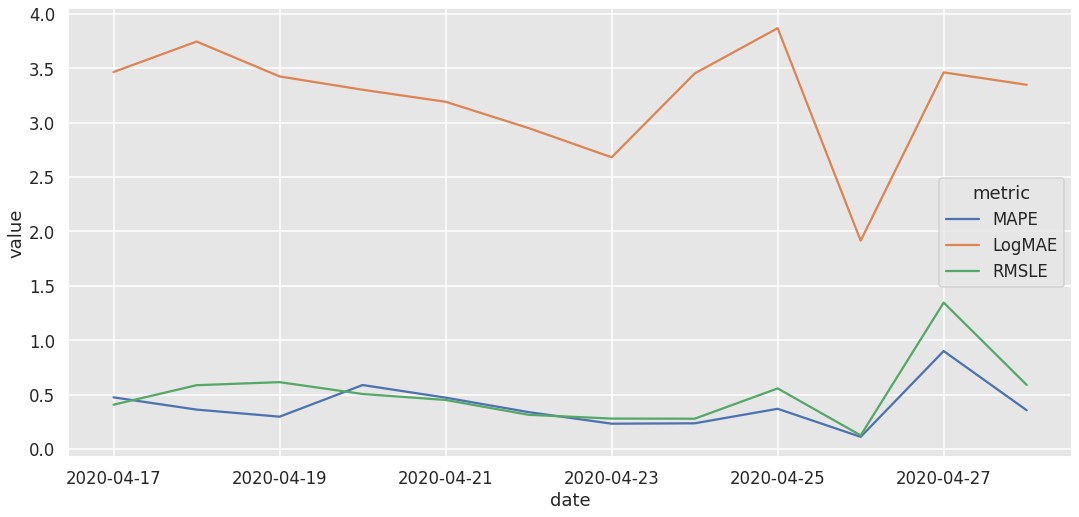

In [ ]:
days=((np.max(X_train_enc_d[index]).date()-validation_split_date).days//test_period)*test_period - 1

scores_mape = pd.DataFrame(np.array(scores_mape), columns = ['value'])
scores_mape['metric']='MAPE'
scores_mape['date']=pd.date_range(start=validation_split_date + relativedelta(days=+1),end=validation_split_date + relativedelta(days=+days), freq = str(test_period)+'D')

scores_mae= pd.DataFrame(np.array(scores_mae), columns = ['value'])
scores_mae['metric']='LogMAE'
scores_mae['date']=pd.date_range(start=validation_split_date + relativedelta(days=+1),end=validation_split_date + relativedelta(days=+days), freq = str(test_period)+'D')

scores_rmsle= pd.DataFrame(np.array(scores_rmsle), columns = ['value'])
scores_rmsle['metric']='RMSLE'
scores_rmsle['date']=pd.date_range(start=validation_split_date + relativedelta(days=+1),end=validation_split_date + relativedelta(days=+days), freq = str(test_period)+'D')

scores = pd.concat((scores_mape, scores_mae), axis=0)
scores = pd.concat((scores, scores_rmsle), axis=0)

fig, ax = plt.subplots()
fig.set_size_inches(18, 8.27)
sns.lineplot(data=scores, x = 'date', y='value', hue='metric')

# **Refit Model with Parameters define on the whole Train**

In [ ]:
from sklearn.linear_model import BayesianRidge
# clf1 = ElasticNet(alpha=0.0001)
clf1 = BayesianRidge()
clf1.fit(X_train_enc, Y_train)
coefs1 = clf1.coef_/np.sum(clf1.coef_)

pred_tr, err_tr = clf1.predict(X_train_enc, return_std=True)
pred_te, err_te = clf1.predict(X_valid_enc, return_std=True)
pred_tr = pred_tr.clip(0)
pred_te = pred_te.clip(0)

coefs=clf1.coef_

# **Check Model Validation Performance and Threshold Approximation Strategy**

RMSE leads to estimating mean and is more sensitive to extreme cases and outliers. MAE leads to estimating median and is more robust to outliers. If RMSE dropped but MAE increased, it means that your model is now better at accounting for extreme cases, but the solution may be less robust.

In [ ]:
print("MAPE Train: %.4f" % mean_absolute_percentage_error(Y_train, pred_tr))
print("LogMAE Train: %.4f" % np.log1p(mean_absolute_error(Y_train, pred_tr)))
print("RMSLE Train: %.4f" % np.sqrt(mean_squared_log_error(Y_train, pred_tr)))

print("MAPE Test: %.4f" % mean_absolute_percentage_error(Y_valid, pred_te))
print("LogMAE Test: %.4f" % np.log1p(mean_absolute_error(Y_valid, pred_te)))
print("RMSLE Test: %.4f" % np.sqrt(mean_squared_log_error(Y_valid, pred_te)))

MAPE Train: 0.5435
LogMAE Train: 2.7125
RMSLE Train: 0.6097
MAPE Test: 0.4130
LogMAE Test: 3.2363
RMSLE Test: 0.7629


# **Show Forecast vs Actual**

In [ ]:
last_ind = 0
df_tr = pd.DataFrame()
# rows_per_loc = int(X_train.shape[0]/len(loc_cols))
for idx, loc in enumerate(loc_cols):
          filter = X_train_enc['LOCATION_ID_'+str(loc)]==1 
          pred_tr_loc = pred_tr[filter]
          Y_train_loc = Y_train[filter]
          X_train_enc_loc = X_train_enc[filter]
          err_tr_loc = err_tr[filter]

          pre_tr = pd.DataFrame()
          pre_tr['value']=pred_tr_loc
          pre_tr['metric']='Forecast'
          pre_tr['location_id']=loc
          pre_tr.index = pd.to_datetime(X_train_enc_loc.index, format = '%Y-%m-%d')
          pre_tr['low']=pre_tr['value']- err_tr_loc
          pre_tr['upp']=pre_tr['value']+ err_tr_loc

          act_tr = pd.DataFrame()
          act_tr ['value']=Y_train_loc.values.squeeze()
          act_tr ['metric']='Actual'
          act_tr['location_id']=loc
          act_tr.index = pd.to_datetime(X_train_enc_loc.index, format = '%Y-%m-%d')

          if df_tr.empty:
                  df_tr = pd.concat((pre_tr, act_tr), axis=0).reset_index()
          else:
                  batch = pd.concat((pre_tr, act_tr), axis=0).reset_index()

                  df_tr = pd.concat((df_tr, batch), axis = 0)
          
          last_ind = 0 

# df_tr = pd.concat((pre_tr, act_tr), axis=0).reset_index()
df = pd.concat((pred_act, df_tr), axis=0)

plotting = pred_act.groupby(['location_id']).agg(lambda x: ','.join(x))
for group in plotting.index:
    fig = plt.figure(figsize=(50,10))
    
    ax = fig.add_subplot(221)
    fig.set_size_inches(50, 18)
    
    df_p = df[(df['location_id']==group) & (df['validdate'].dt.date >=datetime.date(2020,3,10))].sort_values(by='validdate', ascending=True)
    idx = df_p[df_p['metric']=='Forecast']['validdate']
    low = df_p[df_p['metric']=='Forecast']['low']
    upp = df_p[df_p['metric']=='Forecast']['upp']
    
    ax = sns.lineplot(data = df_p, x='validdate', y='value', hue='metric')
    ax.axvline((validation_split_date), label='validation_start', color='r', linestyle='--', lw=2)
    plt.fill_between(idx, low, upp, alpha=.3)
    plt.title('Forecast vs Actual '+ str(group))
    plt.legend()

plt.show()

# **Show Model Coefficients**

In [ ]:
pd.set_option('display.max_colwidth', 1000)
coefficients = pd.concat([pd.DataFrame(X_train_enc.columns),pd.DataFrame(np.transpose(coefs))], axis = 1)
coefficients.columns = ['variable', 'weight']
coefficients['percent']=np.abs(coefficients['weight'])/np.sum(np.abs(coefficients['weight']))
coefficients.sort_values(by = 'weight', ascending = False).head(70)

,variable,weight,percent
145,effective_cloud_cover:p_gt_48.15|categories_impact.sports_lt_66163.5|global_rad_12h:J_gt_21196798.0,38.83,0.04
76,evaporation_12h:mm_lt_-3.37,38.08,0.04
67,clear_sky_energy_12h:J_gt_25397684.0,34.11,0.03
78,t_max_2m_12h:C_gt_33.199999,33.77,0.03
73,sunshine_duration_12h:min_gt_604.049988,30.80,0.03
37,heat_index:C_gt_30.1,29.27,0.03
31,t_apparent:C_gt_32.15,23.71,0.02
138,categories_impact.sports_lt_66163.5|t_apparent:C_gt_32.15,23.71,0.02
70,evapotranspiration_12h:mm_gt_4.44,17.21,0.02
186,precip_12h:mm_gt_3.855|t_apparent:C_gt_32.15,16.27,0.02


# **Show Feature Importance Plot**

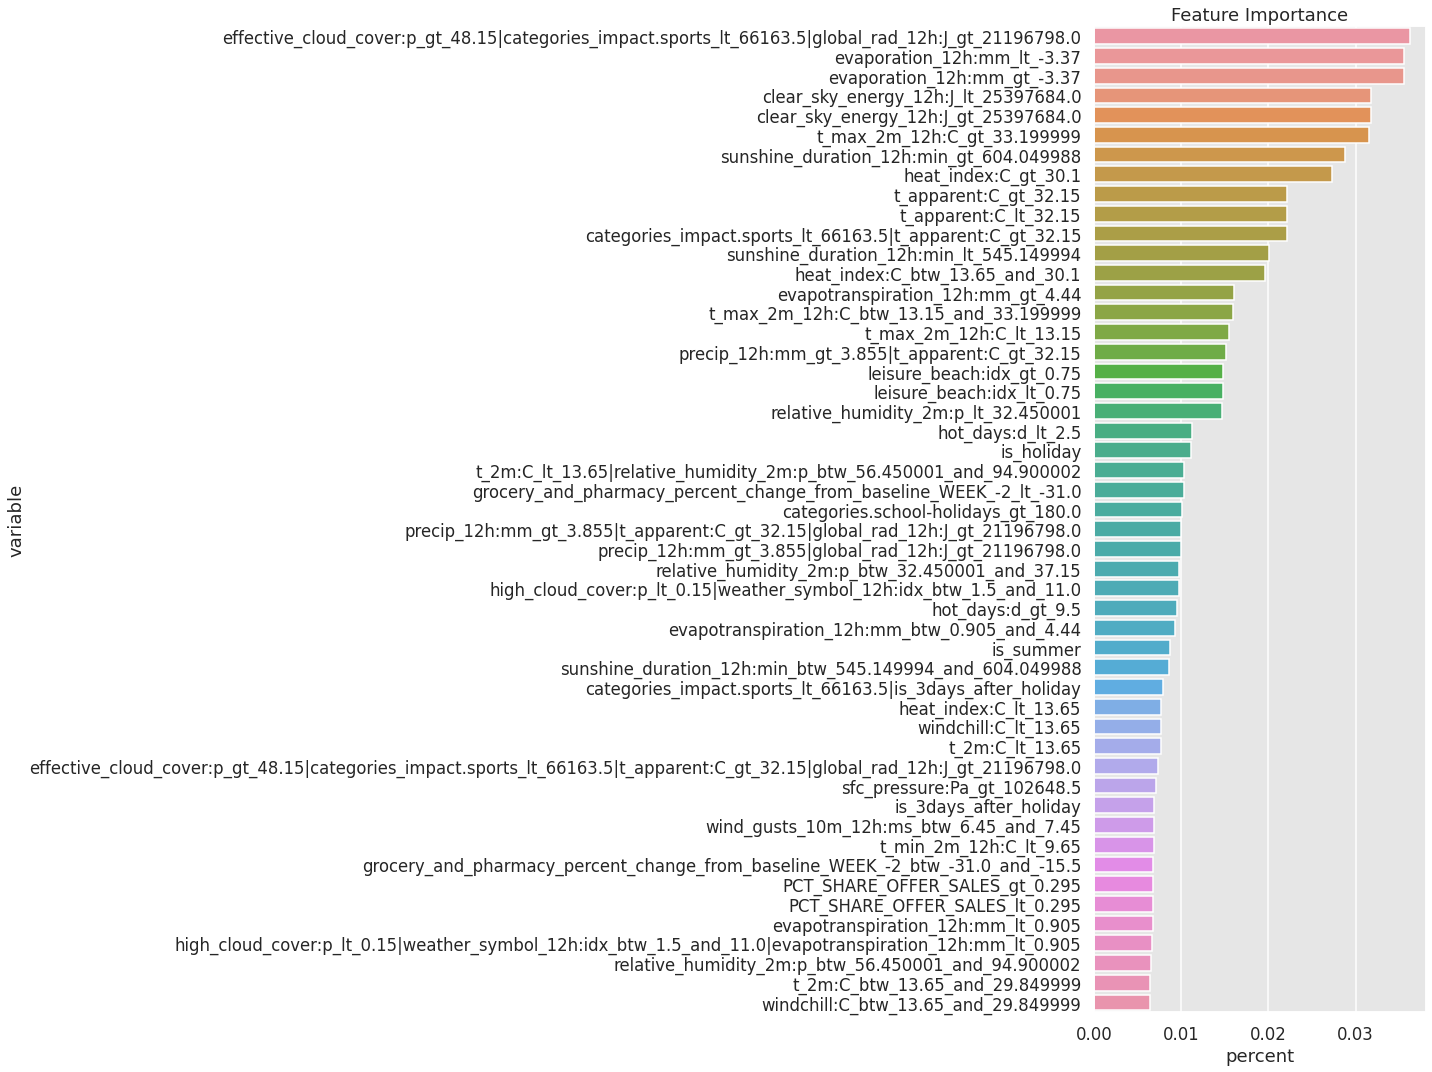

In [ ]:
import seaborn as sns
plt.figure(figsize=(20, 15))
splot = sns.barplot(x="percent", y="variable", data=coefficients.sort_values(by="percent", ascending=False).head(50))

plt.title('Feature Importance')
plt.tight_layout()

# **Explore Interesting Rulesets (RFE-like)**

In [ ]:
draw_interactions = get_variables(coefficients, top=100)
i = 0
while len(draw_interactions) > 20:
      i += 1
      print('Ruleset Num. ' + str(i))
      print('')

      top_feature = draw_feature(draw_interactions, max_depth = 2, min_samples_leaf = 10)
      draw_interactions = list(set(draw_interactions)-set([top_feature[0]]))
      # print(draw_interactions)
      print('')
      print(200*'=')

# **Refit the Whole Model for Unknown Test Based of Full Data**

In [ ]:
use_features = ['LOCATION_ID', 'PCT_SHARE_OFFER_SALES','wind_dir_10m:d', 'wind_speed_10m:ms', 
                't_2m:C', 'relative_humidity_2m:p', 'sfc_pressure:Pa', 't_apparent:C',
                'windchill:C', 'heat_index:C', 'leisure_beach:idx',
                'effective_cloud_cover:p', #  'tropical_nights:d',
                'growing_degree_days_accumulated:gdd', 'hot_days:d',
                'high_cloud_cover:p', 'leaf_wetness:idx', 'global_rad_12h:J', 'wind_gusts_10m_12h:ms',
                'precip_12h:mm', 'weather_symbol_12h:idx','snow_warning_12h:idx', 'clear_sky_energy_12h:J',
                'evapotranspiration_12h:mm', 'sunshine_duration_12h:min',
                'evaporation_12h:mm', 't_max_2m_12h:C', 't_min_2m_12h:C'] + cols_c + cols_e

train['LOCATION_ID']=train['LOCATION_ID'].astype('str')

X = train.set_index(index)[use_features]
X_test = test.set_index(index)[use_features]
Y = -train.set_index(index)[target]
Yd = np.log1p(train.set_index(index)['SALES'])-np.log1p(train.set_index(index)['MODEL']).reindex(Y.index)

cols_old = X.columns
X, cols = date_features(X, index)
X, cols = holiday_features(X, index)
X_test, cols = date_features(X_test, index)
X_test, cols = holiday_features(X_test, index)
use_features+= list(set(cols)-set(cols_old))

mape_scorer = make_scorer(mape, greater_is_better=False)
X_enc, X_test_enc= encode_float_tree(X, X_test.fillna(0), Yd, use_features, numeric_col, target, n_folds, param_grid, mape_scorer)

cat_col = list(X_enc.select_dtypes(include=['object']).columns) 
X_enc, X_test_enc, X_cols, X_test_cols = encode_data_ohe(X_enc, X_test_enc, Y, use_features, bool_col, cat_col)

xgb_features = []
feature_monotones = []

for f1 in tqdm(X_enc.columns):
    for ix, f2 in enumerate(good_features):
       if (f2 in f1):
           xgb_features.append(f1)
           feature_monotones.append(int(good_mono[ix]))

dtrain = xgb.DMatrix(X_enc[xgb_features], label = Yd.clip(0))

params = {'max_depth': 6,
          'eta': 0.1,
          # 'alpha': 0.1,
          'gamma': 10,
          'silent': 1,
          'nthread': 1,
          'min_child_weight': 25,
          'seed': 42,
          'tree_method': 'hist',
          'grow_policy': 'lossguide',
          'eval_metric': 'mae',
          'objective': 'reg:gamma',
          # E.g. fitting three features with positive, negative and no constraint
          # 'monotone_constraints': (1,-1,0)
          'monotone_constraints': '(' + ','.join([str(m) for m in feature_monotones]) + ')'
         }

bst = xgb.train(params, dtrain, num_boost_round = bst_cv.shape[0])

X_enc, X_test_enc, X_cols, X_test_cols = add_interactions(X_enc, X_test_enc, bst, gain_rank_filter = gain_rank_filter)

100%|██████████| 153/153 [00:00<00:00, 111064.12it/s]


# **Fit the Bayesian Linear Regression for the Second Level**

In [ ]:
from sklearn.linear_model import BayesianRidge
# clf1 = ElasticNet(alpha=0.0001)
clf1 = BayesianRidge()
clf1.fit(X_enc, Y)
coefs1 = clf1.coef_/np.sum(clf1.coef_)

pred_tr, err_tr = clf1.predict(X_enc, return_std=True)
pred_te, err_te = clf1.predict(X_test_enc, return_std=True)
pred_tr = pred_tr.clip(0)
pred_te = pred_te.clip(0)

coefs=clf1.coef_
coefficients = pd.concat([pd.DataFrame(X_enc.columns),pd.DataFrame(np.transpose(coefs))], axis = 1)
coefficients.columns = ['variable', 'weight']
coefficients['percent']=np.abs(coefficients['weight'])/np.sum(np.abs(coefficients['weight']))
coefs = coefficients[np.round(coefficients['percent'],2)>0].sort_values(by='percent')

# **Thank you!**